# Analysis of pollsters rating by Five-Thirty-Eight
## Dr. Tirthajyoti Sarkar, Fremont, CA, June 2020

Five-Thirty-Eight especially prides itself on their unique strength of assigning a rating to every pollster, whose polling data they assimilate in their predictive models. They proclaim to do this based on the historical accuracy and methodology of each firm’s polls.

They also publish the curated dataset on this ranking here: https://github.com/fivethirtyeight/data/tree/master/pollster-ratings

Details on this dataset can be found here: https://projects.fivethirtyeight.com/pollster-ratings/

### Import libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.optimize import curve_fit

c:\program files\python37\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Read in the dataset directly from the URL

In [2]:
url = "https://raw.githubusercontent.com/fivethirtyeight/data/master/pollster-ratings/pollster-ratings.csv"

In [3]:
try:
    df = pd.read_csv(url)
except:
    print("Could not retrieve the data!")

### Show column names

In [4]:
for c in df.columns:
    print(c,end=', ')

Pollster, Pollster Rating ID, # of Polls, NCPP / AAPOR / Roper, Live Caller With Cellphones, Methodology, Banned by 538, Predictive    Plus-Minus, 538 Grade, Mean-Reverted Bias, Races Called Correctly, Misses Outside MOE, Simple Average Error, Simple Expected Error, Simple Plus-Minus, Advanced Plus-Minus, Mean-Reverted Advanced Plus Minus, # of Polls for Bias Analysis, Bias, House Effect, Average Distance from Polling Average (ADPA), Herding Penalty, latest_poll, 

### Dataset info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 453 entries, 0 to 452
Data columns (total 23 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   Pollster                                      453 non-null    object 
 1   Pollster Rating ID                            453 non-null    int64  
 2   # of Polls                                    453 non-null    int64  
 3   NCPP / AAPOR / Roper                          453 non-null    object 
 4   Live Caller With Cellphones                   453 non-null    object 
 5   Methodology                                   453 non-null    object 
 6   Banned by 538                                 453 non-null    object 
 7   Predictive    Plus-Minus                      453 non-null    float64
 8   538 Grade                                     453 non-null    object 
 9   Mean-Reverted Bias                            402 non-null    obj

### Rename a column to remove extra spaces

In [6]:
df.rename(columns={'Predictive    Plus-Minus':'Predictive Plus-Minus'},inplace=True)

### Convert `Races Called Correctly` to float from string

In [7]:
df['Races Called Correctly'][:3]

0    81%
1    79%
2    72%
Name: Races Called Correctly, dtype: object

In [8]:
def percent_to_float(x):
    """
    Converts percentage to float
    """
    return float(x[:-1])/100

In [9]:
df['Races Called Correctly']=df['Races Called Correctly'].apply(percent_to_float)

In [10]:
df['Races Called Correctly'][:3]

0    0.81
1    0.79
2    0.72
Name: Races Called Correctly, dtype: float64

### Extract partisan bias from the `Bias` column

In [11]:
def bias_party_id(x):
    """
    Returns a string indicating partisan bias
    """
    if x is np.nan: return "No data"
    x = str(x)
    if x[0]=='D': return "Democratic"
    else: return 'Republican'

In [12]:
def bias_party_degree(x):
    """
    Returns a string indicating partisan bias
    """
    if x is np.nan: return np.nan
    x = str(x)
    return float(x[3:])

In [13]:
df['Partisan Bias']=df['Bias'].apply(bias_party_id)

In [14]:
df['Partisan Bias Degree']=df['Bias'].apply(bias_party_degree)

In [15]:
df[['Pollster','Bias','Partisan Bias','Partisan Bias Degree']].sample(5)

,Pollster,Bias,Partisan Bias,Partisan Bias Degree
363,Craciun Research Group,D +18.7,Democratic,18.7
43,Abt Associates,D +3.3,Democratic,3.3
163,Central Surveys Inc.,D +1.7,Democratic,1.7
107,Dittman Research,D +4.6,Democratic,4.6
294,Mellman Group,D +4.4,Democratic,4.4


### Examine and quantize the `538 Grade` column

In [16]:
df['538 Grade'].unique()

array(['A+', 'A/B', 'A', 'A-', 'B+', 'F', 'B/C', 'B', 'B-', 'C+', 'C',
       'C-', 'C/D', 'D+', 'D-'], dtype=object)

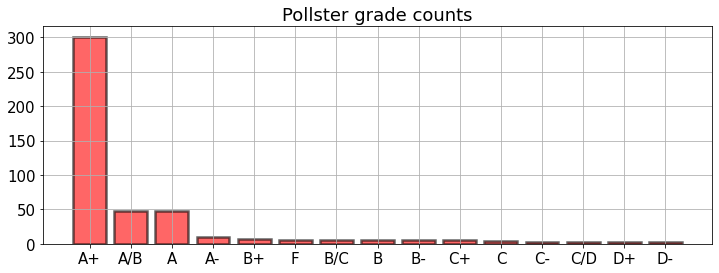

In [17]:
plt.figure(figsize=(12,4))
plt.title("Pollster grade counts",fontsize=18)
plt.bar(x=df['538 Grade'].unique(),
        height=df['538 Grade'].value_counts(),
       color='red',alpha=0.6,edgecolor='k',linewidth=2.5)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.grid(True)
plt.show()

In [18]:
def grade_numeric(x):
    """
    Quantizes the letter grades
    """
    if x[0]=='A': return 4
    if x[0]=='B': return 3
    if x[0]=='C': return 2
    if x[0]=='D': return 1
    else: return 0

In [19]:
df['Numeric grade']=df['538 Grade'].apply(grade_numeric)

In [20]:
df['Numeric grade'].value_counts()

3    320
4     61
2     58
0     10
1      4
Name: Numeric grade, dtype: int64

### Boxplots

In [21]:
def custom_boxplot(x,y,rot=90):
    plt.figure(figsize=(12,4))
    plt.title("Boxplot of \"{}\" by \"{}\"".format(y,x),fontsize=17)
    sns.boxplot(x=x,y=y,data=df)
    plt.xticks(rotation=rot,fontsize=12)
    plt.yticks(fontsize=13)
    plt.xlabel(x,fontsize=15)
    plt.ylabel(y+'\n',fontsize=15)
    plt.show()

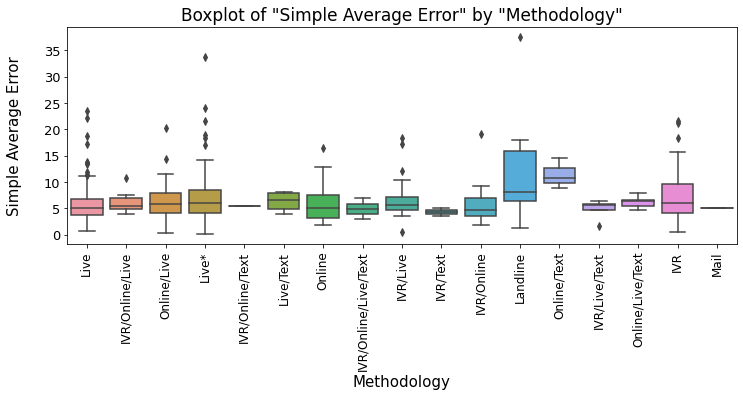

In [22]:
custom_boxplot(x='Methodology',y='Simple Average Error')

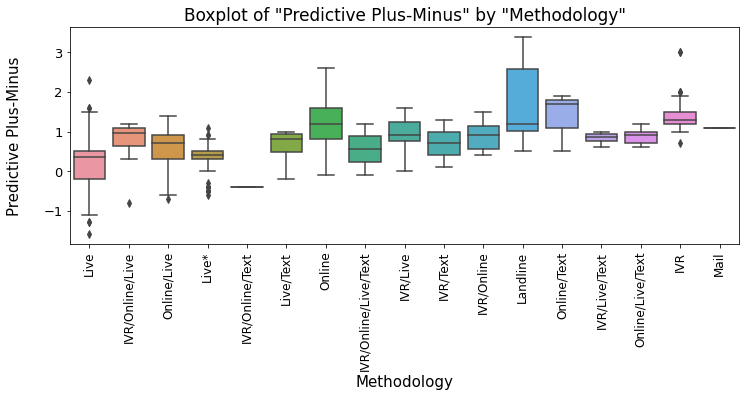

In [23]:
custom_boxplot(x='Methodology',y='Predictive Plus-Minus')

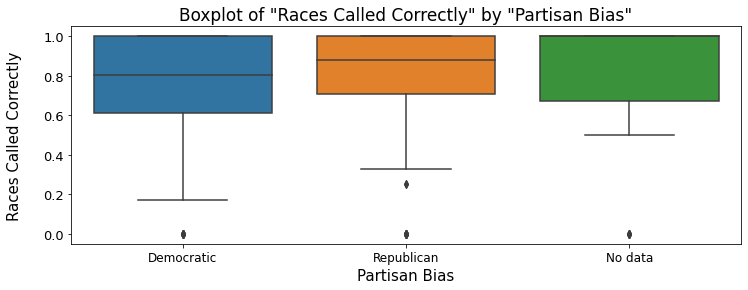

In [24]:
custom_boxplot(x='Partisan Bias',y='Races Called Correctly',rot=0)

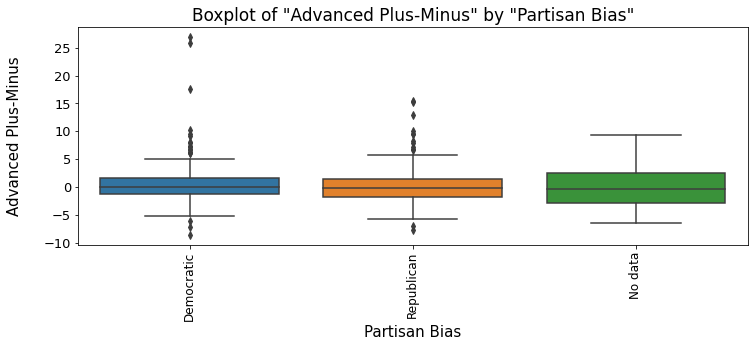

In [25]:
custom_boxplot(x='Partisan Bias',y='Advanced Plus-Minus')

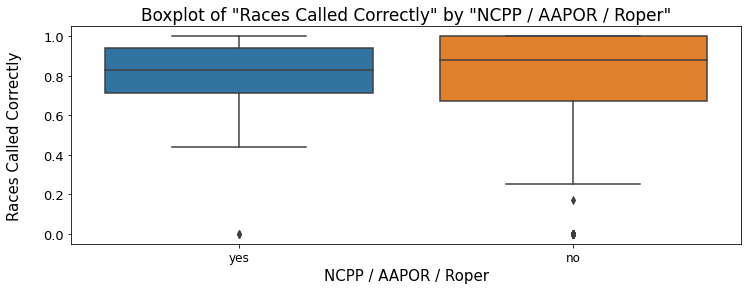

In [26]:
custom_boxplot(x='NCPP / AAPOR / Roper',y='Races Called Correctly',rot=0)

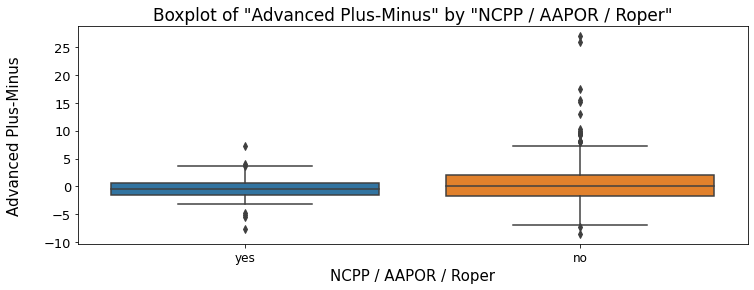

In [27]:
custom_boxplot(x='NCPP / AAPOR / Roper',y='Advanced Plus-Minus',rot=0)

## Scatter and regression plots

In [28]:
def custom_scatter(x,y,data=df,pos=(0,0),regeqn=True):
    """
    Plots customized scatter plots with regression fit using Seaborn
    """    
    sns.lmplot(x=x,y=y,data=data,height=4,aspect=1.5,
       scatter_kws={'color':'yellow','edgecolor':'k','s':100},
              line_kws={'linewidth':3,'color':'red','linestyle':'--'})
    
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.xlabel(x,fontsize=15)
    plt.ylabel(y+'\n',fontsize=15)
    ax = plt.gca()
    ax.set_title("Regression fit of \"{}\" vs. \"{}\"".format(x,y),fontsize=15)
    
    if (regeqn):
        slope, intercept, r_value, p_value, std_err = stats.linregress(df[x],df[y])
        r_squared = r_value**2
        eqn= "$y$={0:.3f}$x$+{1:.3f},\n$R^2$:{2:.3f}".format(slope,intercept,r_squared)
        plt.annotate(s=eqn,xy=pos,fontsize=13)

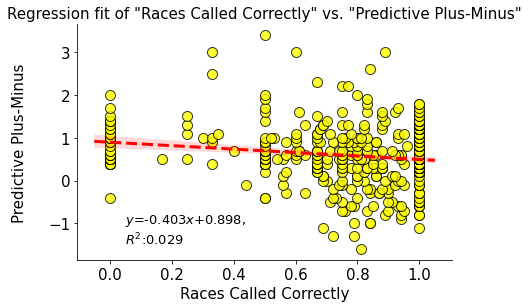

In [29]:
custom_scatter(x='Races Called Correctly',
               y='Predictive Plus-Minus',
              pos=(0.05,-1.5))

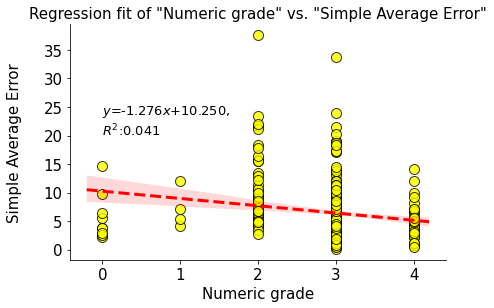

In [30]:
custom_scatter(x='Numeric grade',
               y='Simple Average Error',
              pos=(0,20))

In [31]:
df.columns

Index(['Pollster', 'Pollster Rating ID', '# of Polls', 'NCPP / AAPOR / Roper',
       'Live Caller With Cellphones', 'Methodology', 'Banned by 538',
       'Predictive Plus-Minus', '538 Grade', 'Mean-Reverted Bias',
       'Races Called Correctly', 'Misses Outside MOE', 'Simple Average Error',
       'Simple Expected Error', 'Simple Plus-Minus', 'Advanced Plus-Minus',
       'Mean-Reverted Advanced Plus Minus', '# of Polls for Bias Analysis',
       'Bias', 'House Effect', 'Average Distance from Polling Average (ADPA)',
       'Herding Penalty', 'latest_poll', 'Partisan Bias',
       'Partisan Bias Degree', 'Numeric grade'],
      dtype='object')

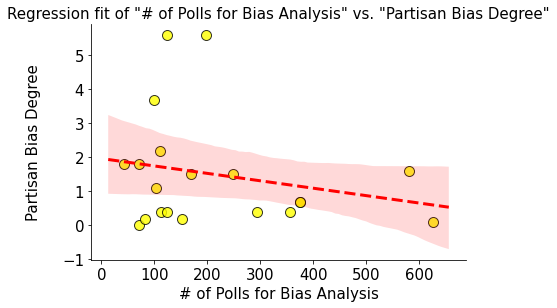

In [32]:
df_2 = df.dropna()
filtered = df_2[df_2['# of Polls']>100]
custom_scatter(x='# of Polls for Bias Analysis',
              y='Partisan Bias Degree',
              data=filtered,regeqn=False)

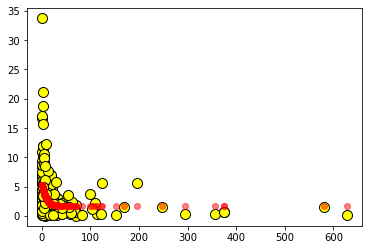

In [33]:
x = df_2['# of Polls for Bias Analysis']
y = df_2['Partisan Bias Degree']
            
plt.scatter(x,y,color='yellow',edgecolors='k',s=100)

def func(x, a, b, c):
    return a * np.exp(-b *0.1*x) + c
popt, pcov = curve_fit(func, x, y)
y_fit = func(x,popt[0],popt[1],popt[2])
plt.scatter(x,y_fit,color='red',alpha=0.5)
plt.show()

c:\program files\python37\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


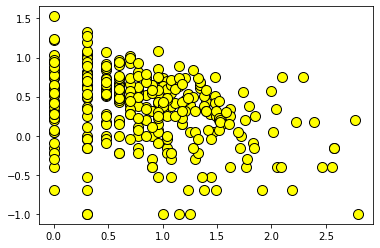

In [34]:
plt.scatter(np.log10(np.abs(x)),np.log10(np.abs(y)),color='yellow',edgecolors='k',s=100)

In [35]:
popt

array([4.02787718, 1.27296008, 1.70702939])

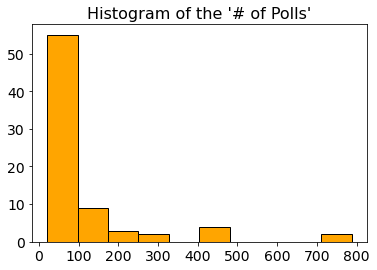

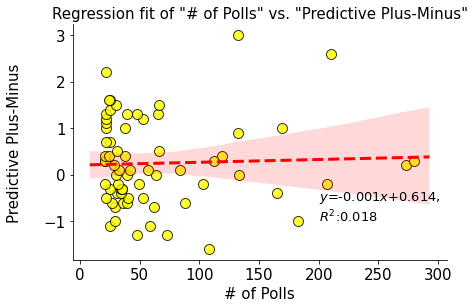

In [36]:
filtered = df[df['# of Polls']>20]
plt.title("Histogram of the \'# of Polls\'",fontsize=16)
plt.hist(filtered['# of Polls'],color='orange',edgecolor='k')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

filtered =filtered[filtered['# of Polls']<400]
custom_scatter(x='# of Polls',
               y='Predictive Plus-Minus',
               pos = (200,-1),
               data=filtered)

In [37]:
df_scores = df[['Predictive Plus-Minus','Races Called Correctly',
                'Simple Average Error','Advanced Plus-Minus',
               'Numeric grade']]

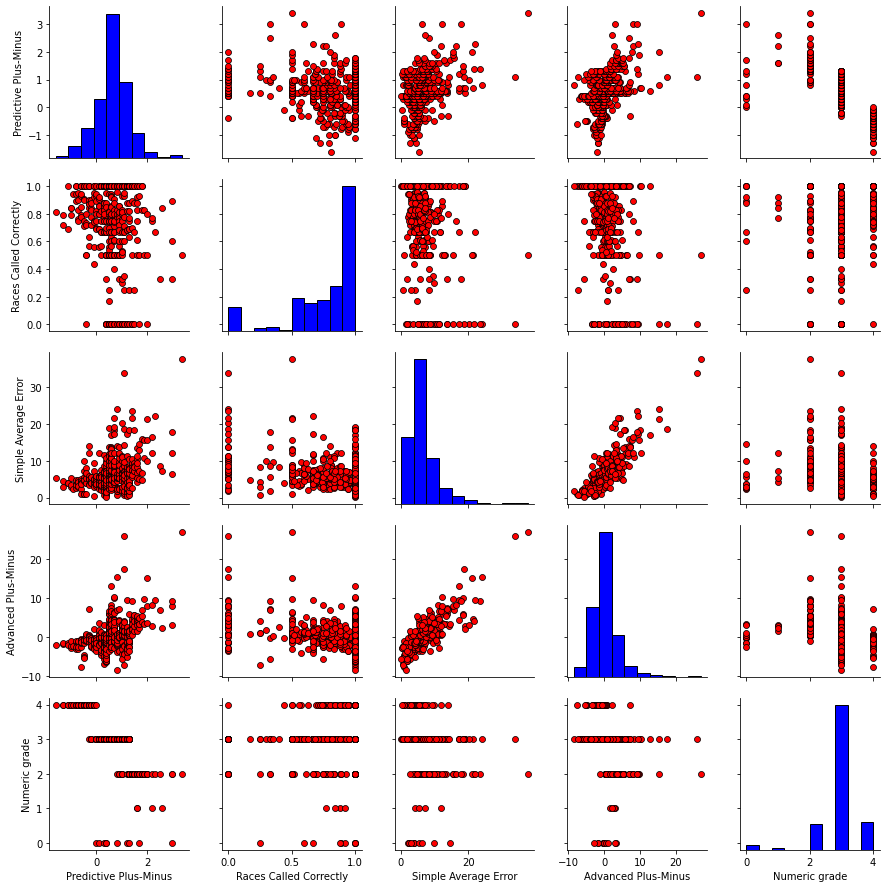

In [38]:
sns.pairplot(data=df_scores,
             plot_kws={'color':'red','edgecolor':'k'},
             diag_kws={'color':'blue','edgecolor':'k'})

### Filtering and sorting

In [39]:
df_sorted = df[df['# of Polls']>50].sort_values(by=['Advanced Plus-Minus'])[:10]
df_sorted[['Pollster','# of Polls','Advanced Plus-Minus','Partisan Bias','538 Grade']]

,Pollster,# of Polls,Advanced Plus-Minus,Partisan Bias,538 Grade
0,Monmouth University,108,-2.0,Democratic,A+
2,ABC News/The Washington Post,73,-1.7,Democratic,A+
3,Siena College/The New York Times Upshot,59,-1.5,Republican,A+
11,SurveyUSA,787,-1.1,Democratic,A
7,Marist College,183,-1.0,Republican,A+
15,CBS News/The New York Times,62,-1.0,Democratic,A
31,Siena College,53,-0.9,Republican,A-
39,Emerson College,165,-0.7,Democratic,A-
49,Mason-Dixon Polling & Strategy,433,-0.6,Republican,B+
19,Suffolk University,88,-0.6,Democratic,A


In [40]:
df['House Effect']

0       R +0.4
1       D +0.2
2       D +1.3
3       D +0.4
4       D +0.6
        ...   
448     D +2.9
449     D +9.9
450     R +3.5
451     D +3.0
452    D +10.9
Name: House Effect, Length: 453, dtype: object